# Análisis de datos - Trabajo final integrador

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQATNC-EBwF-LIbDVv_L0gkP2V6oKQzah5GRg&usqp=CAU"/>

Se propone realizar el ciclo completo del desarrollo de un modelo de aprendizaje automático supervisado.

Trabajaremos con un [dataset de Kaggle con datos de por distintas estaciones metereológicas de Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv).

Se proponen dos objetivos: 
1. Predecir si lloverá o no al día siguiente (variable *RainTomorrow*), en función datos metereológicos del día actual.
2. Predecir el volúmen de precipitaciones (columna *Rainfall* ), en función de los datos meteorológicos restantes.


##Enunciado

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Descargar el [dataset de kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv)

### 1. Análisis exploratorio inicial

- Visualizar las primeras filas.
- Realizar un resumen de 5 números.
- Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).
- Identificar las variables de entrada y de salida del problema.
- Variables de entrada:
  - Realizar los siguientes análisis por tipo de variable.
    - Numéricas: 
      - Obtener conclusiones acerca de la distribución de los datos.
    - Categóricas
        - Obtener conclusiones acerca de cardinalidad, representación de cada categoría, etc.
    - Compuestas/otros. ¿Cómo pueden tratarse para utilizarlas en el problema elegido?
- Variables de salida:
  - ¿Están balanceadas las clases?
  - ¿Qué técnicas consideraría para codificar la variable de salida? Justificar.

### 2. Esquema de validación de resultados

- Los pasos siguientes comprenden las etapas de preparación de datos y evaluación de resultados. Todos los puntos analizarlos para los dos problemas planteados.
- Para ello, se debe particionar el dataset en entrenamiento y validación.

### 3. Limpieza y preparación de datos / ingeniería de features

- Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable.
- ¿Qué supuestos puede realizar acerca de los datos faltantes? ¿Qué técnicas de imputación recomendaría?. Ensayar distintas técnicas y analizar los resultados. 
- En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de datos compuestos o estructurados, considerar la obtención de variables de tipo númerico/categórico.
- ¿Qué puede decir acerca de las relaciones entre las variables de entrada?

- Antes de entrenar un modelo de aprendizaje automático, ¿Podría identificar las variables de entrada de mayor importancia?. Considerar por lo menos dos técnicas para cada variable. Explique brevemente los métodos utilizados.

### 4. Entrenamiento de modelos

- Para cada uno de los problemas propuestos, defina una lista de modelos candidatos a entrenar. Justifique sus elecciones. 

- Ensaye distintas cadenas de procesamiento con las técnicas consideradas en la sección 3 (por ejemplo, distintas técnicas de imputación, selección de variables de entrada, codificación de variables categóricas, transformación, etc.).

### 5. Evaluación de resultados y conclusiones

- ¿Qué puede concluir acerca de los modelos y preparaciones de datos ensayadas? Tener en cuenta como cada preparación afecta a los distintos modelos.

### 6. Presentación de resultados

- Elabore un informe de dos o tres páginas describiendo el procedimiento realizado y las conclusiones importantes indicando la ruta del código fuente en git.


In [2]:
!pip install funpymodeling

In [3]:
!pip install geopy

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import funpymodeling as fp
from geopy.geocoders import Nominatim
import re
import calendar
from math import radians

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Desarrollo

### **1. Análisis exploratorio inicial**

In [5]:
# Importar el dataset crudo
rawDataset = pd.read_csv('/content/drive/MyDrive/CEIA_UBA/06-Analisis de datos/Tp Integrador Sesto/weatherAUS.csv')

In [6]:
# Visualizar las primeras 5 filas
rawDataset.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
# Con pd.info se puede apreciar cuales son las variables del tipo numéricas (float64)
# y cuales son del tipo categóricas (object)
rawDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

##### **Variables de entrada**

In [8]:
rawDataset.drop('RainTomorrow', axis=1, inplace=False).columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')

##### **Variable de salida**

In [9]:
rawDataset['RainTomorrow'].name

'RainTomorrow'

#### **Variables de entrada**
Se procede a clasificar las variables de entrada entre numéricas o categóricas y a analizar la correlación entre ellas.
##### Variables numéricas:

In [10]:
rawDataset.dtypes[rawDataset.dtypes.array!='O']

MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustSpeed    float64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
dtype: object

In [11]:
rawDataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0


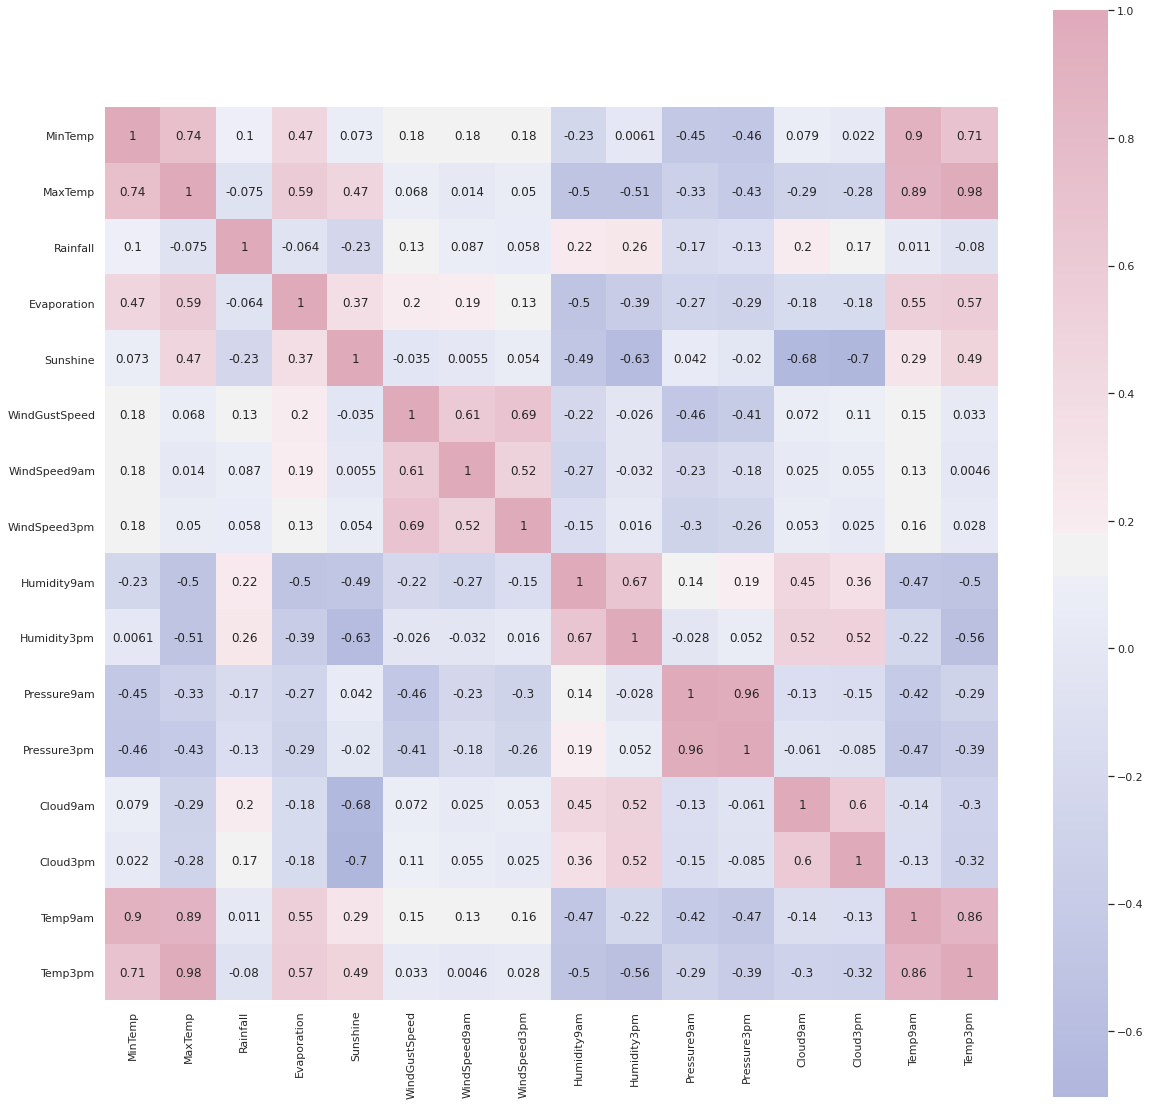

In [12]:
corrMat = rawDataset.corr()
cmap = sns.diverging_palette(260,-10,s=50,l=75, n=6, as_cmap=True)
plt.subplots(figsize=(20,20))
sns.heatmap(corrMat, cmap=cmap, annot=True, square=True)

Gracias al gráfico anterior podemos apreciar las correlaciones entre algunas variables, se procede a analizar grandes correlaciones como:
* Temperaturas: MinTemp, MaxTemp, Temp9am y Temp3pm.
* Velocidad del viento: WindGustSpeed, WindSpeed9am, WindSpeed3pm.
* Precipitación, Evaporación y Humedad.

In [13]:
def plots(df, features, sharex="row", sharey="row", figsize=(30,15)):
    
    nrows = 2
    ncols = len(features)
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=sharex, sharey=sharey, figsize=figsize)
    fig.suptitle("Distribuciones de {}".format(', '.join(features)), fontsize=32)

    for i, col in enumerate(features):
        ax[0, i].boxplot(df.loc[df[col].isna()==False, col])
        ax[0, i].set_title("Boxplot {}".format(col))
        ax[1, i].hist(df.loc[df[col].isna()==False, col])
        ax[1, i].set_title("Histograma {}".format(col))
    
    plt.show()

**Temperatura**

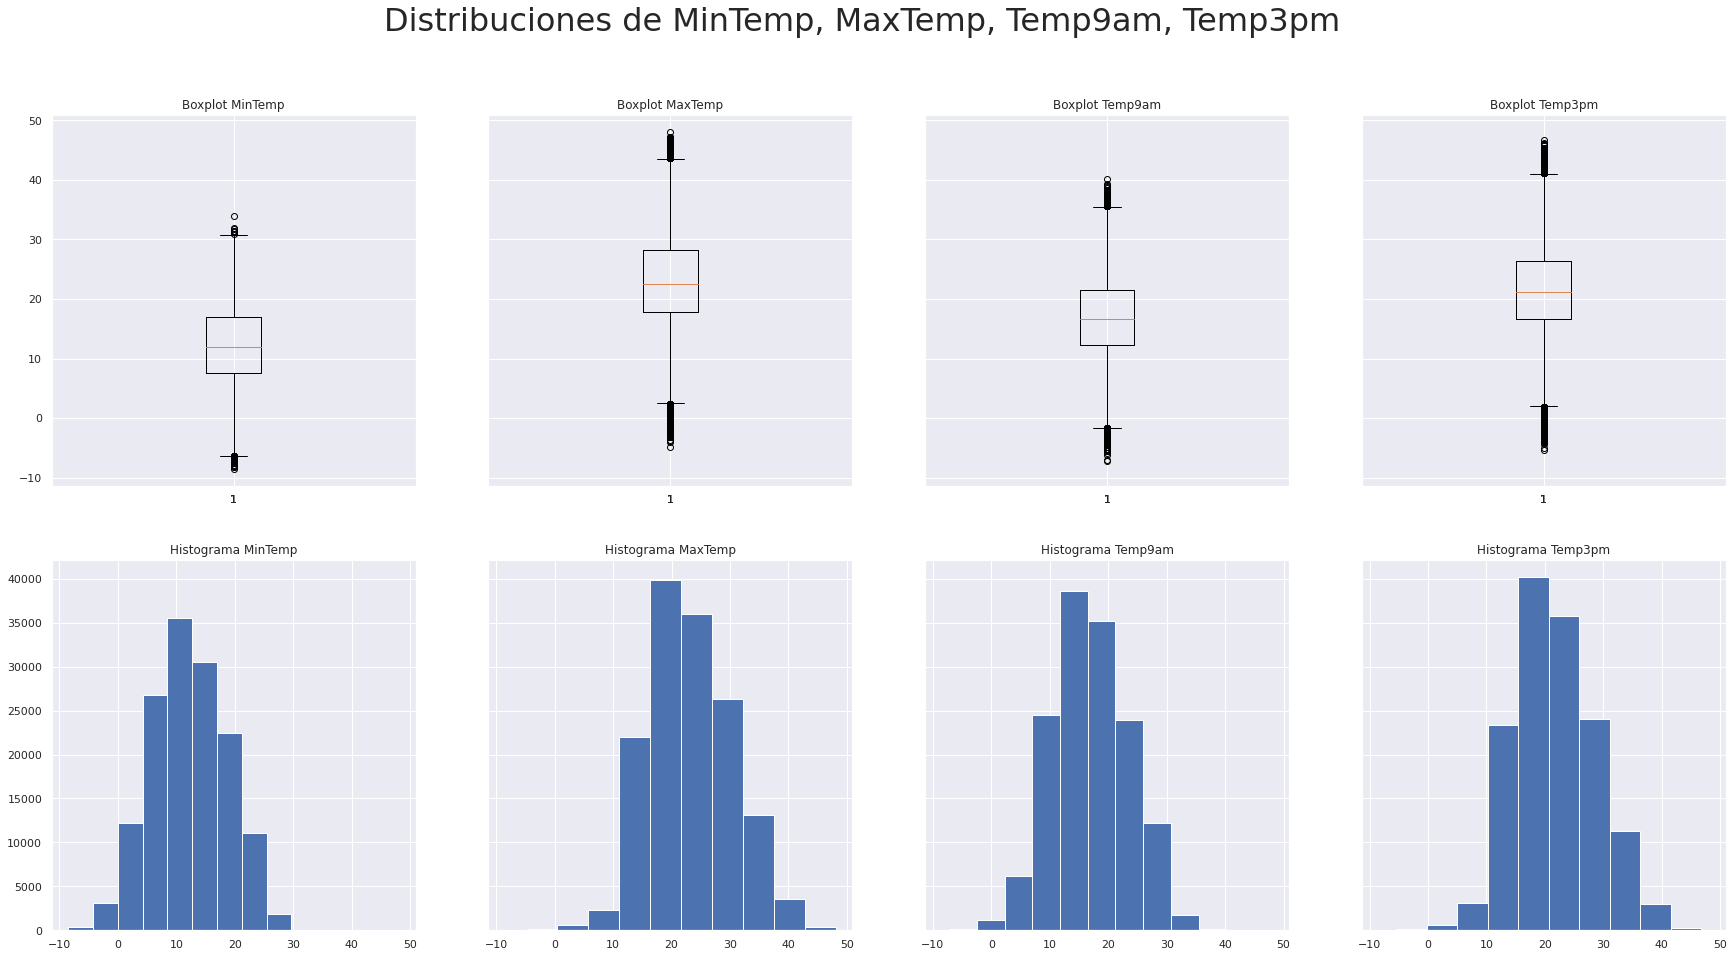

Correlaciones entre las variables dado conocimientos sobre las condiciones.


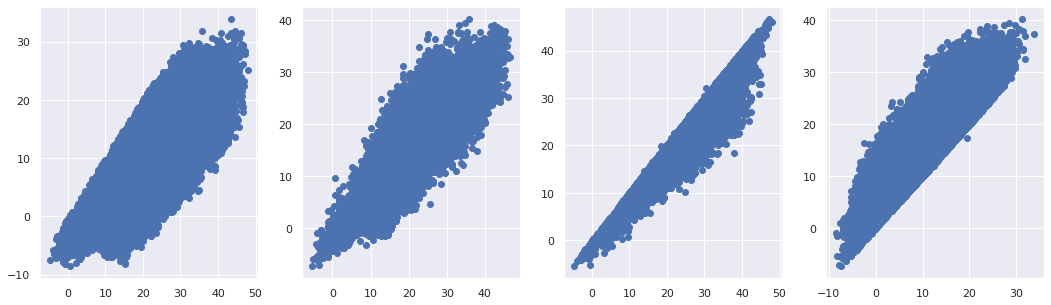

In [14]:
plots(df=rawDataset, features=['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm'])
print("Correlaciones entre las variables dado conocimientos sobre las condiciones.")
fig, ax = plt.subplots(1, 4, figsize=(18,5))
ax[0].scatter(rawDataset['MaxTemp'], rawDataset['MinTemp'])
ax[1].scatter(rawDataset['Temp3pm'], rawDataset['Temp9am'])
ax[2].scatter(rawDataset['MaxTemp'], rawDataset['Temp3pm'])
ax[3].scatter(rawDataset['MinTemp'], rawDataset['Temp9am'])


A partir de los histogramas se observa que las temperaturas minimas y las temperaturas a las 9 am no presentan grandes diferencia, lo mismo para el caso de la temperatura maxima y la temperatura a las 3pm. Ambas tiene una distribucion normal, centrada, por lo que no se realizaran transformaciones en ese sentido. Esto nos induce a analizar la correlacion entre estas variables y de ser alta, se eliminaria para no trabajar con datos duplicados.

**Sol, nubosidad 9am, nubosidad 3pm**

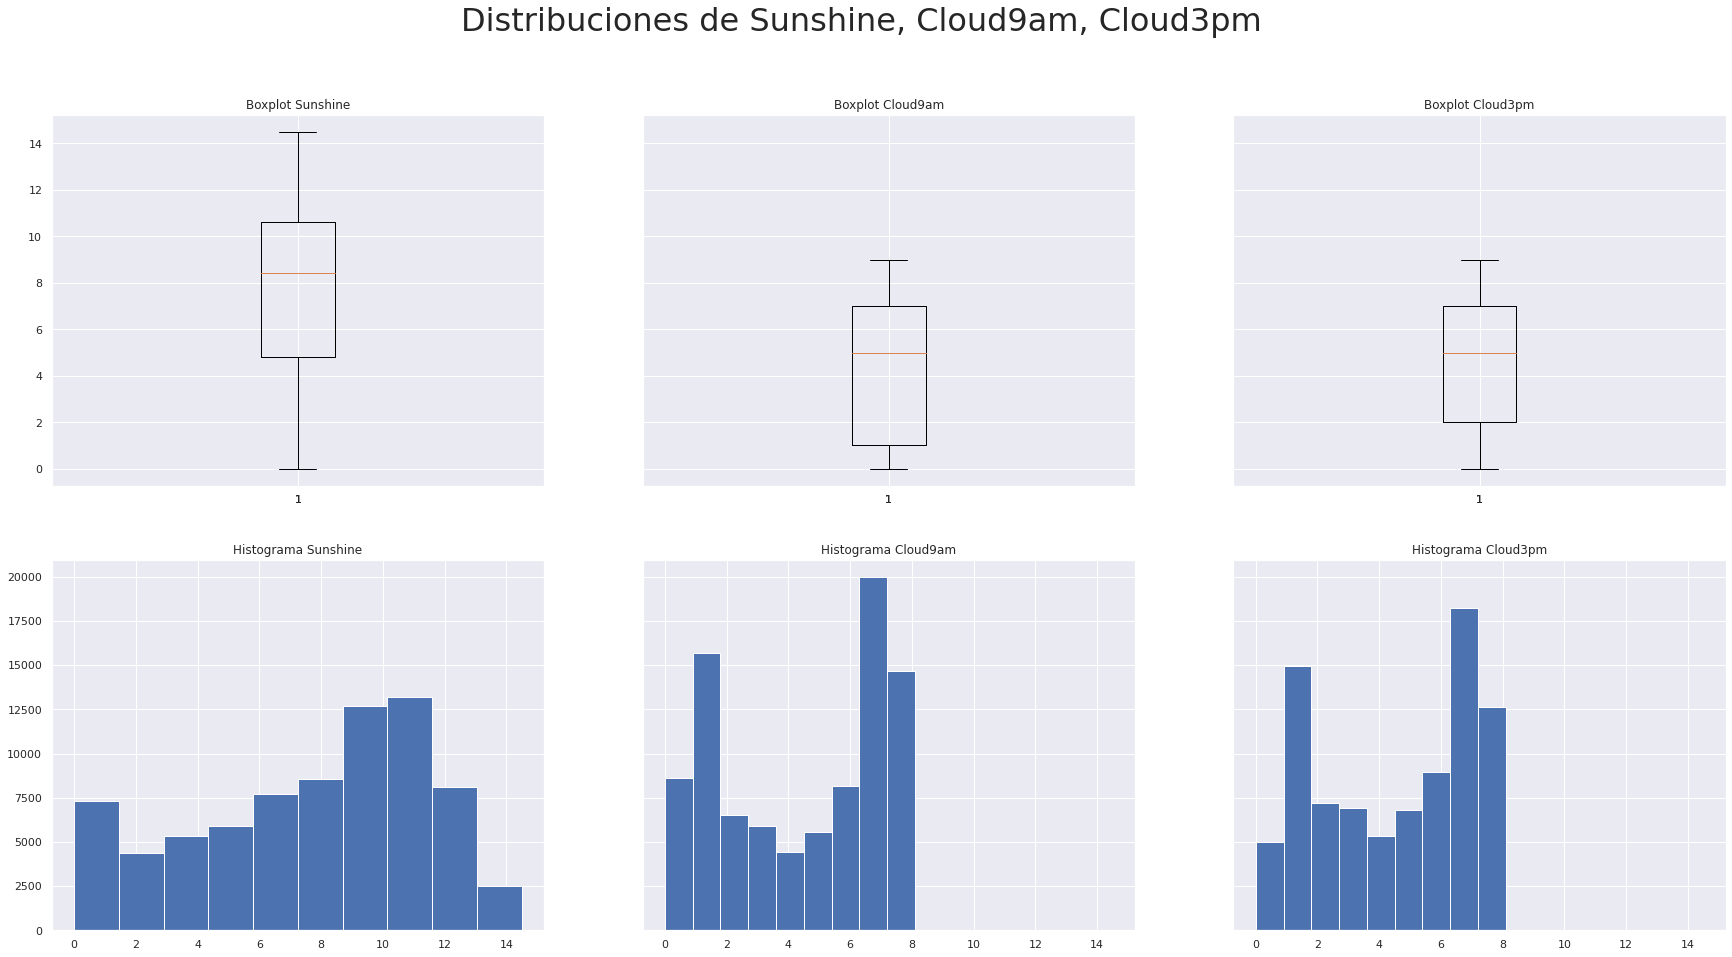

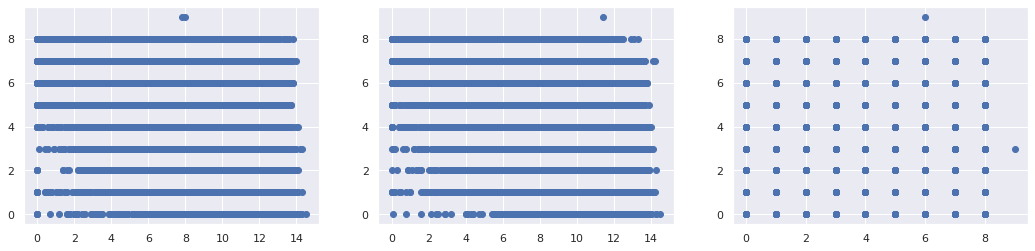

In [15]:
plots(df=rawDataset, features=['Sunshine', 'Cloud9am', 'Cloud3pm'])
fig, ax = plt.subplots(1, 3, figsize=(18,4))
ax[0].scatter(rawDataset['Sunshine'], rawDataset['Cloud9am'])
ax[1].scatter(rawDataset['Sunshine'], rawDataset['Cloud3pm'])
ax[2].scatter(rawDataset['Cloud9am'], rawDataset['Cloud3pm'])


Se puede observar en los histogramas y boxplot de nubosidad que su distribucion para los valores de nubosidad a las 9am y nubosidad a las 3pm son bastante similares y aparentemene bimodales con gran concentracion de datos a la izquierda y derecha, posiblemente representando nubosidad baja o alta respectivamente, mientras que en el centro hay pocos caso. Para el caso de luz solar, se evidencia un leve corrimiento hacia la derecha. Intuyendo relacion entre nubosidad y luz solar se buscará graficar la misma como se obserba abajo.

Text(0, 0.5, 'Nubosidad 3pm')

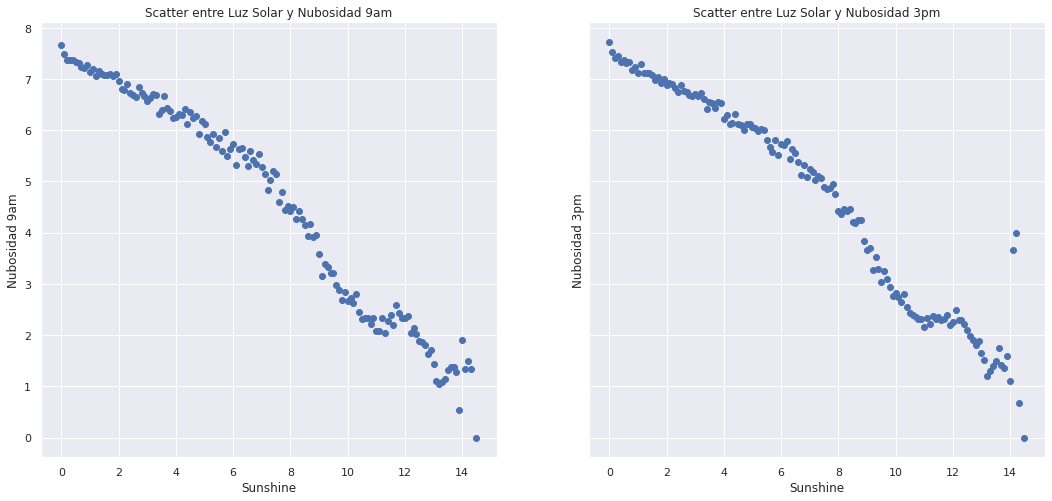

In [16]:
mask_nans = ((rawDataset['Sunshine'].isna()==False) & (rawDataset['Cloud9am'].isna()==False) & (rawDataset['Cloud3pm'].isna()==False))

rawDataset_sunshine_cloud = rawDataset.loc[mask_nans, ['Sunshine', 'Cloud3pm','Cloud9am']].groupby('Sunshine').mean().reset_index()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(18,8))
plt.title('Scatter plot entre Luz Solar y Nubosidad')

ax[0].scatter(rawDataset_sunshine_cloud['Sunshine'], rawDataset_sunshine_cloud['Cloud9am'])
ax[0].set_title('Scatter entre Luz Solar y Nubosidad 9am')
ax[0].set_xlabel('Sunshine')
ax[0].set_ylabel('Nubosidad 9am')

ax[1].scatter(rawDataset_sunshine_cloud['Sunshine'], rawDataset_sunshine_cloud['Cloud3pm'])
ax[1].set_title('Scatter entre Luz Solar y Nubosidad 3pm')
ax[1].set_xlabel('Sunshine')
ax[1].set_ylabel('Nubosidad 3pm')

Como se observa en los graficos anteriores, existe una fuerte correlacion entre luz solar y nubosidad (correlacion negativa) por lo que se puede evaluar descartar algunas de las features. Por otro lado, no se observan grandes diferencias entre la nubosidad entre las 9am y 3pm por lo que se podria omitir uno de esos datos por ser repetidos.

Velocidad del viento

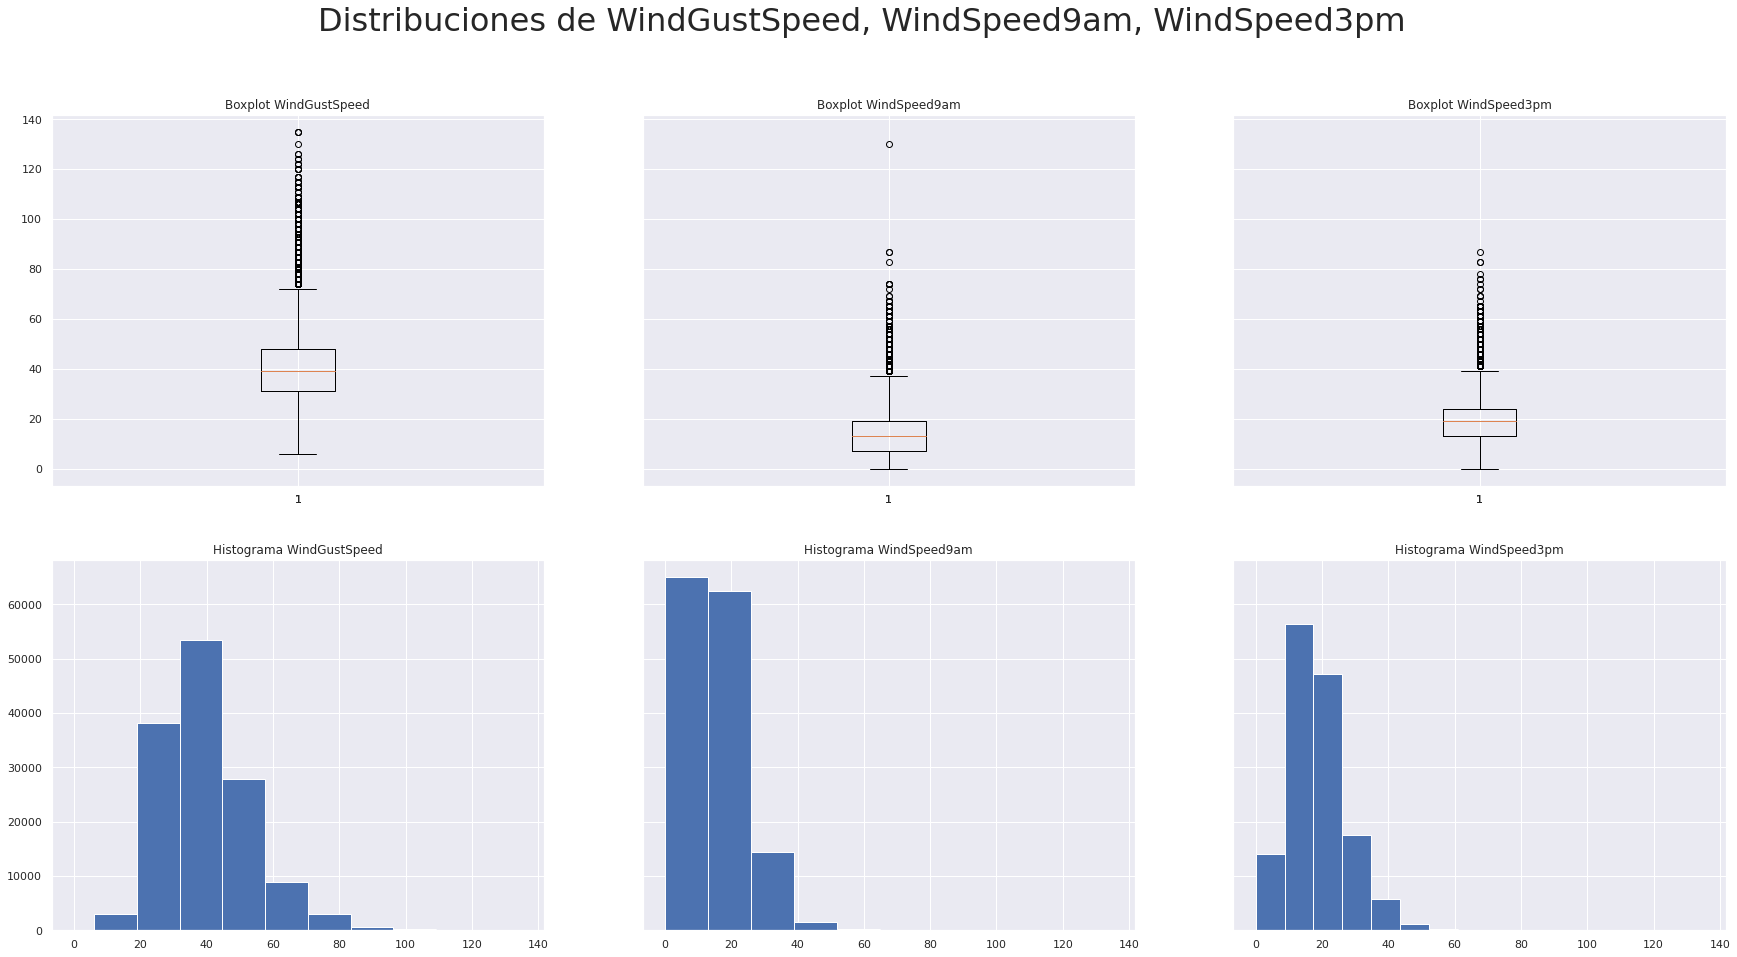

Correlaciones entre las variables dado conocimientos sobre las condiciones.


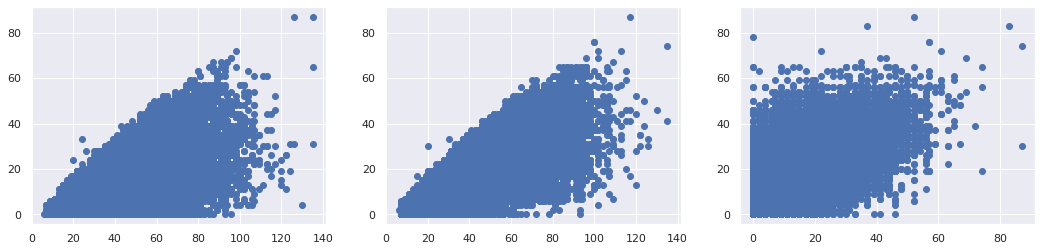

In [17]:
plots(df=rawDataset, features=['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'])
print("Correlaciones entre las variables dado conocimientos sobre las condiciones.")
fig, ax = plt.subplots(1, 3, figsize=(18,4))
ax[0].scatter(rawDataset['WindGustSpeed'], rawDataset['WindSpeed9am'])
ax[1].scatter(rawDataset['WindGustSpeed'], rawDataset['WindSpeed3pm'])
ax[2].scatter(rawDataset['WindSpeed9am'], rawDataset['WindSpeed3pm'])

Como era de esperar la media de los datos de la rafaga de viento son superiores a las del viento a las 9am y 3pm, por otro lado el viento a las 3pm pareciera tener velocidades mas altas que el viento de las 9am, la distribucion de los datos de la velocidad de viento tienen un leve corrimiento hacia la izquierda y en todos los casos se observan bastantes outliers (considerados por rango intercuartilico) con velocidades de viento alto.

*** Precipitación, Evaporación y Humedad.**

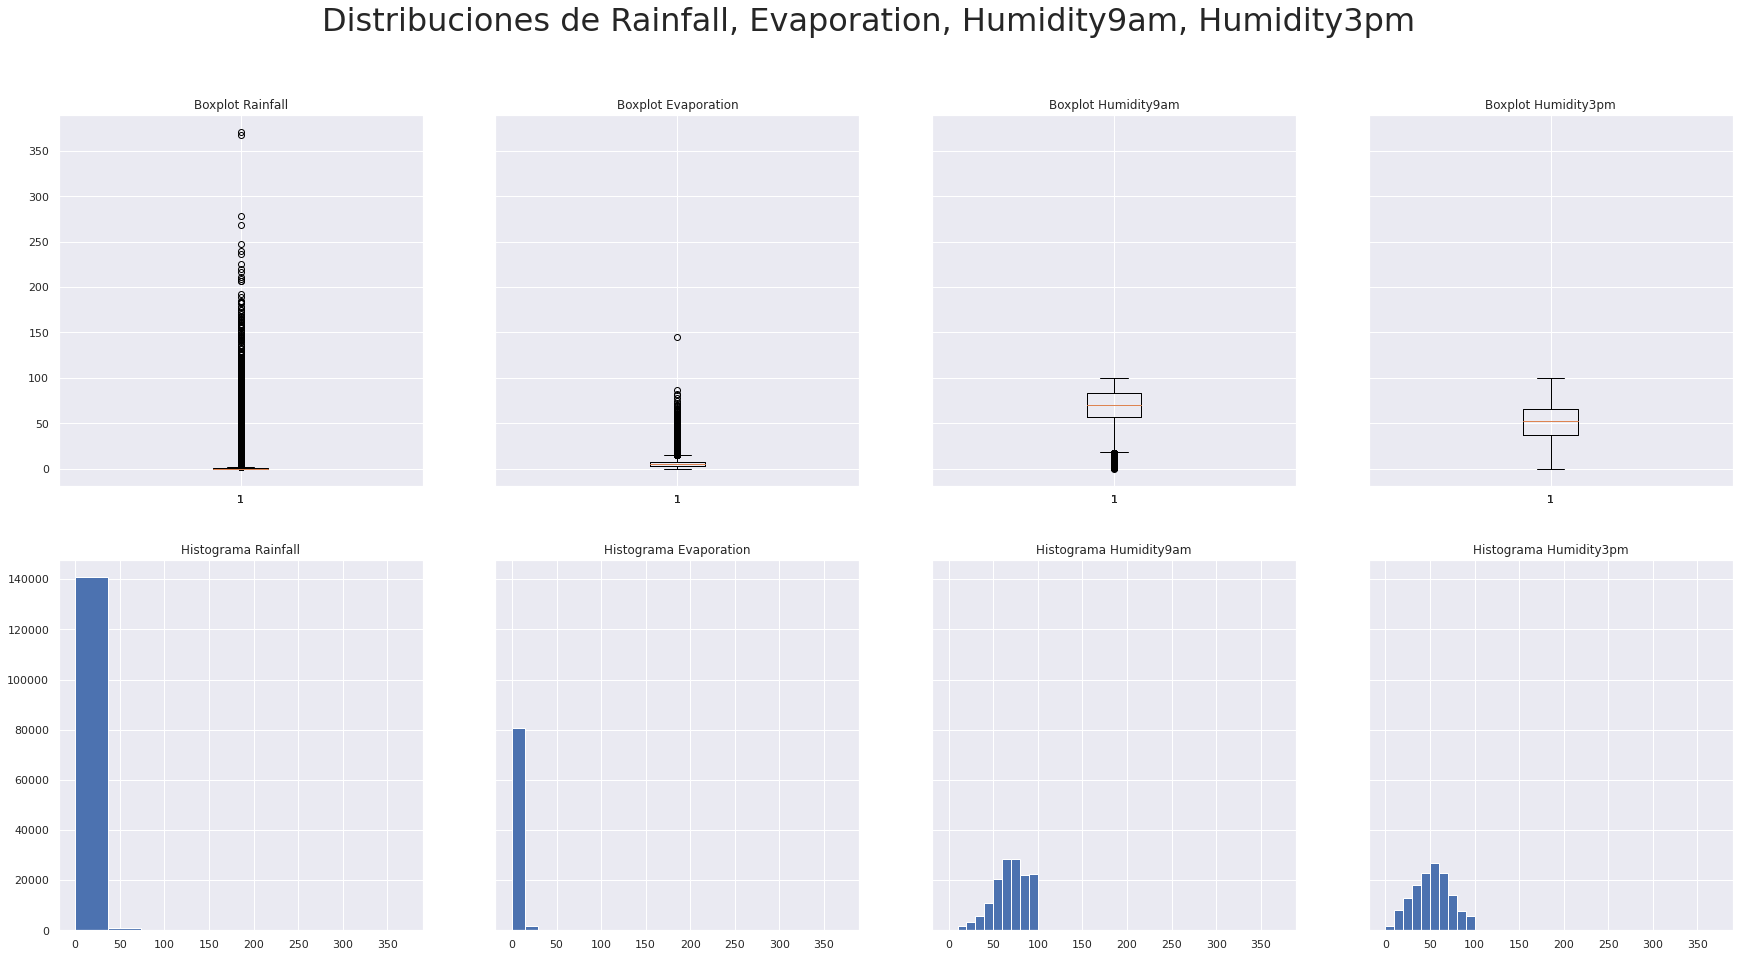

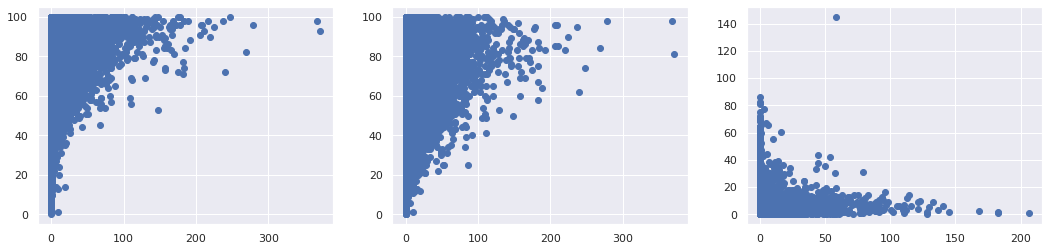

In [18]:
plots(df=rawDataset, features=['Rainfall', 'Evaporation','Humidity9am', 'Humidity3pm'])
fig, ax = plt.subplots(1, 3, figsize=(18,4))
ax[0].scatter(rawDataset['Rainfall'], rawDataset['Humidity9am'])
ax[1].scatter(rawDataset['Rainfall'], rawDataset['Humidity3pm'])
ax[2].scatter(rawDataset['Rainfall'], rawDataset['Evaporation'])

De los boxplots e histogramas de Rainfall y Evaporation, se deduce que los datos están mayoritariamente concentrados en un rango estrecho determinado de la variable y el resto,se considerarían outliers. 
Sería interesante ver la relación de esos outliers con la variable de salida. Vemos que la media de humedad es mayor a la mañana que al medioda, probablemente relacionado con el rocío.
Nuevamente, intuyendo una relación entre humedad y evaporación y precipitación, se realizará un análisis más detallado.

In [19]:
# Por simplesa, armamos una solamáscara para quitar los nans de las columnas a analizar.
# Tomamos como referencia la humedad a las 3 PM que aparenta una distribución normal.

mask_nans = (rawDataset['Rainfall'].isna()==False) & (rawDataset['Humidity3pm'].isna()==False) & (rawDataset['Evaporation'].isna()==False)

dataset_hum_rainfall = rawDataset.loc[mask_nans, ['Humidity3pm', 'Rainfall', 'Evaporation']].groupby('Humidity3pm').mean().reset_index()

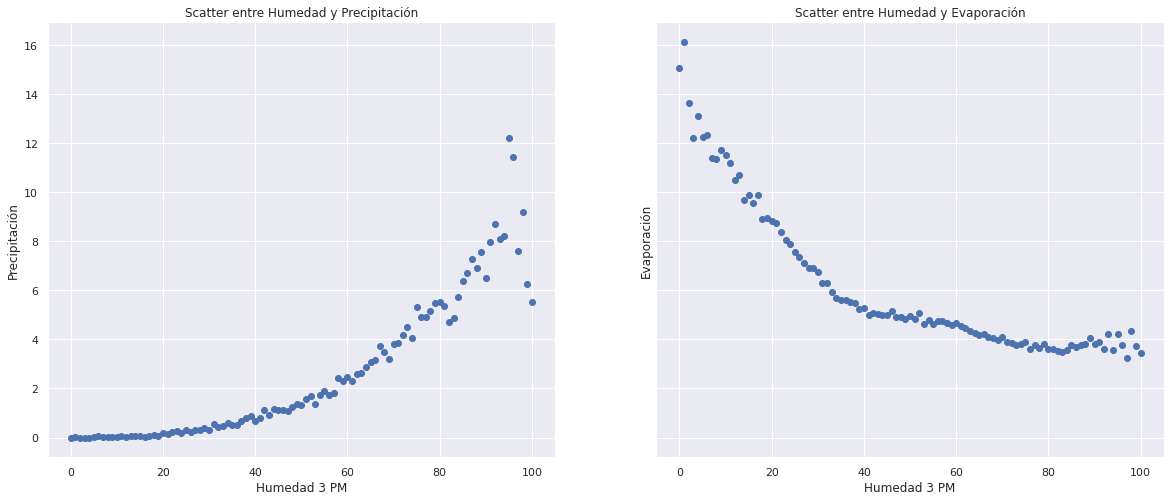

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 8))
plt.title("Scatter plot entre Humedad, Precipitación y Evaporación")

ax[0].scatter(dataset_hum_rainfall['Humidity3pm'], dataset_hum_rainfall['Rainfall'])
ax[0].set_title("Scatter entre Humedad y Precipitación")
ax[0].set_xlabel("Humedad 3 PM")
ax[0].set_ylabel("Precipitación")

ax[1].scatter(dataset_hum_rainfall['Humidity3pm'], dataset_hum_rainfall['Evaporation'])
ax[1].set_title("Scatter entre Humedad y Evaporación")
ax[1].set_xlabel("Humedad 3 PM")
ax[1].set_ylabel("Evaporación")

plt.show()

Se puede observar, en los gráficos de arriba, que existe un relación no lineal entre la humedad y las medias de precipitación y evaporación. En ámbos casos es monotona la relación, creciente y decreciente respectivamente.

####**Variable categórica.**

In [21]:
rawDataset.describe(include = ['object']).T

,count,unique,top,freq
Date,145460,3436,2015-03-09,49
Location,145460,49,Canberra,3436
WindGustDir,135134,16,W,9915
WindDir9am,134894,16,N,11758
WindDir3pm,141232,16,SE,10838
RainToday,142199,2,No,110319
RainTomorrow,142193,2,No,110316


In [22]:
# Listado de ubicaciones en Australia.
print('Cantidad de ubicaciones:' ,rawDataset['Location'].unique().shape[0])
print(rawDataset['Location'].unique())

Cantidad de ubicaciones: 49
['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


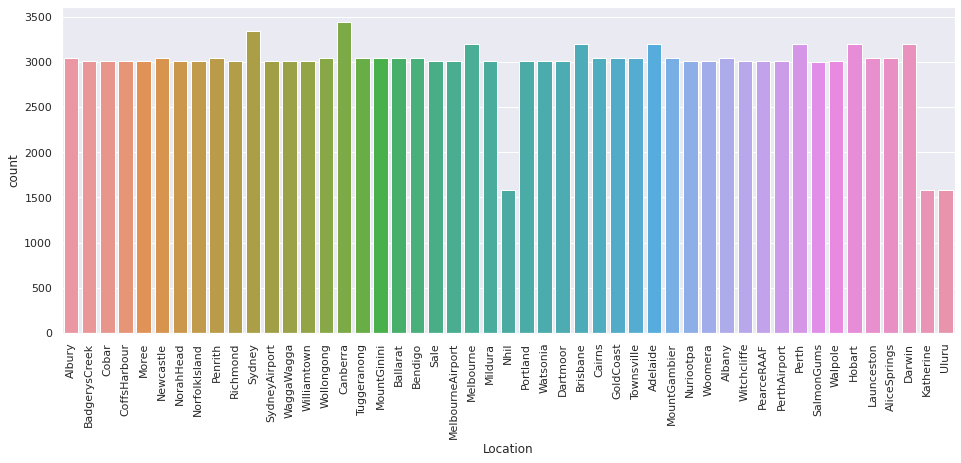

In [23]:
# Cantidad de muestras por ubicación.
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.countplot(rawDataset['Location'], ax=ax)
plt.xticks(rotation=90)
plt.show()

In [24]:
rawDataset['Location'].value_counts().sort_values().head(8)

Uluru               1578
Katherine           1578
Nhil                1578
SalmonGums          3001
NorahHead           3004
Walpole             3006
CoffsHarbour        3009
MelbourneAirport    3009
Name: Location, dtype: int64

En general, vemos una representación similar para cada una de las 49 ubicaciones, exceptuando los casos de Katherine, Uluru y Nhil que tienen menor cantidad de muestras.

Analizamos las direcciones del viento, cuantas categorías tienen y la existencia de NaN.

In [25]:
# Valores de dirección del viento:
print("Cantidad de direcciones:", rawDataset['WindGustDir'].unique().shape[0])
print("Existencia de Nans: ",rawDataset['WindGustDir'].isnull().values.any())
print(rawDataset['WindGustDir'].unique())

print("Cantidad de direcciones:", rawDataset['WindDir9am'].unique().shape[0])
print("Existencia de Nans: ",rawDataset['WindDir9am'].isnull().values.any())
print(rawDataset['WindDir9am'].unique())

print("Cantidad de direcciones:", rawDataset['WindDir3pm'].unique().shape[0])
print("Existencia de Nans: ",rawDataset['WindDir3pm'].isnull().values.any())
print(rawDataset['WindDir3pm'].unique())

Cantidad de direcciones: 17
Existencia de Nans:  True
['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']
Cantidad de direcciones: 17
Existencia de Nans:  True
['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' nan 'SSW' 'N' 'WSW' 'ESE' 'E'
 'NW' 'WNW' 'NNE']
Cantidad de direcciones: 17
Existencia de Nans:  True
['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'N' 'S'
 'NNE' nan 'NE']


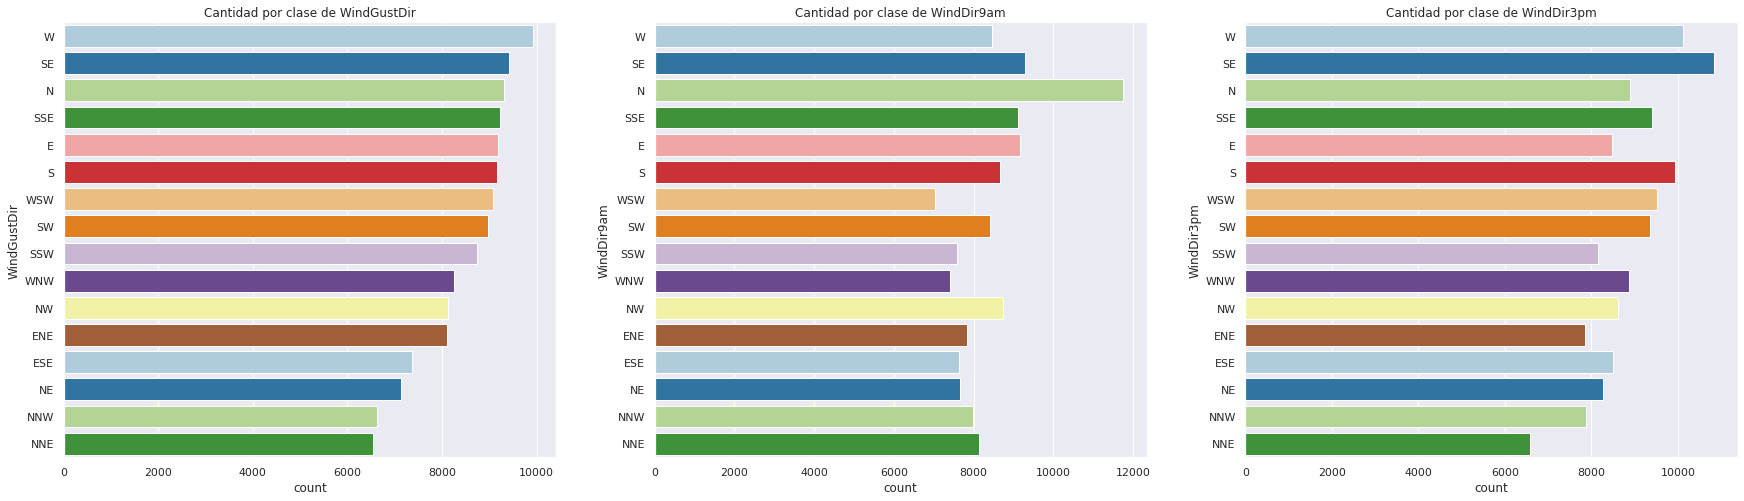

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))

sns.countplot(data=rawDataset, y='WindGustDir', ax = ax[0], palette='Paired', 
              order=rawDataset['WindGustDir'].value_counts().index)

sns.countplot(data=rawDataset, y='WindDir9am', ax = ax[1], palette='Paired', 
              order=rawDataset['WindGustDir'].value_counts().index)

sns.countplot(data=rawDataset, y='WindDir3pm', ax = ax[2], palette='Paired', 
              order=rawDataset['WindGustDir'].value_counts().index)

ax[0].set_title('Cantidad por clase de WindGustDir')
ax[1].set_title('Cantidad por clase de WindDir9am')
ax[2].set_title('Cantidad por clase de WindDir3pm')

plt.show()

Por ultimo observamos la varabiale RainToday, analizamos si posee NaN y si esta balanceada.

No     110319
Yes     31880
Name: RainToday, dtype: int64


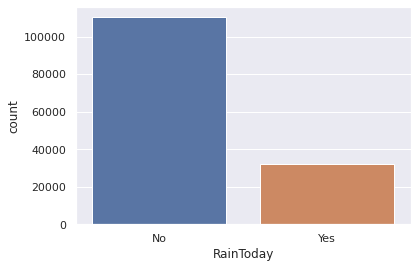

In [27]:
print(rawDataset['RainToday'].value_counts())
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.countplot(rawDataset['RainToday'],ax=ax)
plt.show()

Como se puede observar, la variable RainToday no se encuentra balanceada, teniando mayor cantidad de muestra para casos que no llueve lo que podria producir un sesgo en el resultado de la prediccion de la variable de salida.

####**Variables compuestas.**
La variable fecha 'Date' de cada muestra es una variable compuesta. Se procede a analizar sus valores mínimo y máximo, luego se descompone la variable fecha para analizar la cantidades de lluvia a lo largo del año.

In [28]:
df_date = pd.to_datetime(rawDataset['Date'])

print("Min: " + str(df_date.min()))
print("Max: " + str(df_date.max()))

Min: 2007-11-01 00:00:00
Max: 2017-06-25 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

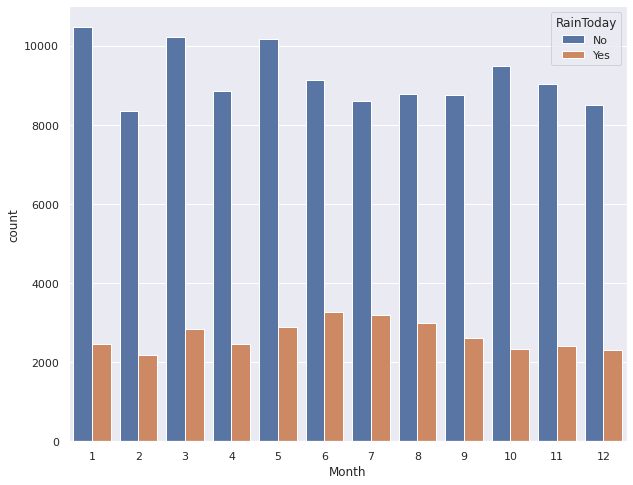

In [29]:
rawDataset['Date'] = pd.to_datetime(rawDataset['Date'])
rawDataset['Day'] = rawDataset['Date'].dt.day
rawDataset['Month'] = rawDataset['Date'].dt.month
rawDataset['Year'] = rawDataset['Date'].dt.year
rawDataset.info()
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.countplot(data=rawDataset, x='Month', hue='RainToday', ax=ax)

In [30]:
rawDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

Por lo observado para los meses de Junio, Julio y Agosto hay un leve aumento de la cantidad de lluvias. Ademas se observa nuevamente la cantidad de datos defasados entre los dias que llueve y los dias que no llueve.

#### **Variable de salida**

La variable de salida es la última columna del dataset la cual indica si lloverá al día siguiente, de forma categórica con los valores "Yes" y "No". A continuación se analiza la cantidad de NaNs y si la variables está balanceada o ocurre algo similar a la variable 'RainToday'.

In [31]:
print("Cantidad de muestras:", rawDataset['RainTomorrow'].shape[0])
print("Cantidad de Nans:", rawDataset['RainTomorrow'].isna().sum())
print("Porcentaje de NaNs respecto de las muestras: {:.2f}%".format(
      rawDataset['RainTomorrow'].isna().sum()/rawDataset['RainTomorrow'].shape[0]*100))

Cantidad de muestras: 145460
Cantidad de Nans: 3267
Porcentaje de NaNs respecto de las muestras: 2.25%


No     110316
Yes     31877
Name: RainTomorrow, dtype: int64


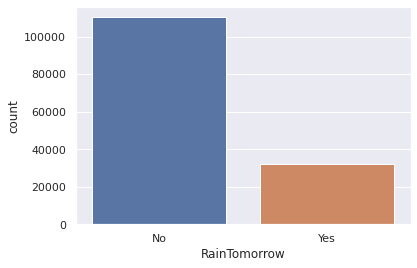

In [32]:
print(rawDataset['RainTomorrow'].value_counts())
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.countplot(rawDataset['RainTomorrow'],ax=ax)
plt.show()

Porcentaje de Clase Yes: 21.91%
Porcentaje de Clase No: 75.84%


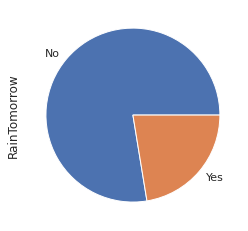

In [33]:
# Proporción de clases:
print("Porcentaje de Clase Yes: {:.2f}%".format(
    ((rawDataset['RainTomorrow']=='Yes').sum()/rawDataset['RainTomorrow'].shape[0])*100))
print("Porcentaje de Clase No: {:.2f}%".format(
    ((rawDataset['RainTomorrow']=='No').sum()/rawDataset['RainTomorrow'].shape[0])*100))
rawDataset['RainTomorrow'].value_counts().plot.pie();

Como se puede observar con los datos y los gráficos, la variable de salida está muy desbalanceadas. Idealmente, para entrenar, nuestro dataset debería tener aproximadamente la misma cantidad de casos "Yes" como de casos "No", por lo que se aplicrán técnicas para lidear con este desbalanceo.

Como se trata de un problema de clasificación binaria, para codificar la variable de salida, se transformarán los valores "Yes"/"No" a 1/0 respectivamente. Este encoding tambien será aplicado a la variable RainToday por ser el mismo tipo de dato que la salida.

### **2. Esquema de validación de resultados**

Previo a la separación del dataset en set de entrenamiento y validación, se procede a eliminar las muestras cuya salida es un valor faltante, porque no tendríamos manera de consultar el loss.

In [34]:
rawDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

In [35]:
print("Cantidad de muestras iniciales:", rawDataset.shape)
dfToSplit = rawDataset.copy()
#Como el dataset comienza a ser modificado se utiliza otro nombre y así mantener el dataset original sin cambios.
dfToSplit.dropna(subset=['RainTomorrow'], inplace=True)
print("Cantidad de muestras a utilizar:", dfToSplit.shape)
print("Cantidad de muestras sin valor en la salida:", dfToSplit.RainTomorrow.isna().sum())

Cantidad de muestras iniciales: (145460, 26)
Cantidad de muestras a utilizar: (142193, 26)
Cantidad de muestras sin valor en la salida: 0


Separamos el dataset entre la entrada y la salida, sin alterar el dataframe original luego de limpiar la columna de valores de salida:

In [36]:
y = dfToSplit['RainTomorrow']
X = dfToSplit.drop('RainTomorrow', axis=1, inplace=False)
print("X shape:", X.shape)
print("Y shape:", y.shape)

X shape: (142193, 25)
Y shape: (142193,)


### **3. Limpieza y preparación de datos / ingeniería de features.**

- En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de datos compuestos o estructurados, considerar la obtención de variables de tipo númerico/categórico.
- ¿Qué puede decir acerca de las relaciones entre las variables de entrada?

- Antes de entrenar un modelo de aprendizaje automático, ¿Podría identificar las variables de entrada de mayor importancia?. Considerar por lo menos dos técnicas para cada variable. Explique brevemente los métodos utilizados.



Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable. Esto se analiza en todo el dataset luego de la limpieza de la salida.

In [37]:
datosFaltantes = X.isnull().sum()
porcentajeFaltante= datosFaltantes/X.shape[0] * 100
values = {
    "datosFaltantes": datosFaltantes,
    "porcentajeFaltante%" : porcentajeFaltante,
}
nansInfo = pd.DataFrame(values)
nansInfo.sort_values('porcentajeFaltante%', ascending = False)

,datosFaltantes,porcentajeFaltante%
Sunshine,67816,47.692924
Evaporation,60843,42.789026
Cloud3pm,57094,40.152469
Cloud9am,53657,37.735332
Pressure9am,14014,9.855619
Pressure3pm,13981,9.832411
WindDir9am,10013,7.041838
WindGustDir,9330,6.561504
WindGustSpeed,9270,6.519308
WindDir3pm,3778,2.656952


De todos los features de nuestro dataset, se debe prestar atencion a sunshine, evaporation cloud3pm y cloud9am que presentan un porcentaje de valores faltantes mayores a 37%.
Analizamos la cantidad de muestras con al menos un valor faltante:

In [38]:
nans = X.loc[dfToSplit.isna().sum(axis=1) >=1, :]
print("Porcentaje de filas con al menos u NaNs: {:.2f}%". format(nans.shape[0]/X.shape[0]*100))

Porcentaje de filas con al menos u NaNs: 60.32%


Del análisis anterior se desprende que más del 60% de las muestras de nuestro dataset de entrenamiento contienen al menos un NaN, por lo que no se contempla como estrategia de procesamiento, eliminar todas las filas con NaNs.

A continuación, analizaremos las variables con mayor proporción de valores faltantes (Sunshine, Evaporation, Cloud3pm, Cloud9am) para ver si se trata de un caso de MAR, MCAR, o MNAR. Se debería aplicar el análisis a todas las features pero por temas de extensión se focaliza únicamente en éstas.

In [39]:
mask_nan = (X['Sunshine'].isna()==True)
columns = ['Evaporation', 'Cloud3pm', 'Cloud9am']
print("En relación a las muestras de Sunshine con NaN:")
for column in columns:
  porcent = X.loc[mask_nan, column].isna().sum()/X.loc[mask_nan, column].shape[0]*100
  print("Porcentaje de valores faltantes para {}: {:.2f}".format(column,porcent))

En relación a las muestras de Sunshine con NaN:
Porcentaje de valores faltantes para Evaporation: 83.88
Porcentaje de valores faltantes para Cloud3pm: 70.20
Porcentaje de valores faltantes para Cloud9am: 67.48



Como se puede observar, efectivamente cuando tenemos valores faltantes de sunshine, tenemos un alto porcentaje de valores faltantes para nubosidad y evaporación, indincando la posibilidad de que sea el mísmo proceso que esté detrás de los valores faltantes de éstas features. 

In [40]:
mask_nan = (X['Cloud9am'].isna()==True)
nan_perc = X.loc[mask_nan, 'Cloud3pm'].isna().sum()/X.loc[mask_nan, 'Cloud3pm'].shape[0]
print("Porcentaje de valores faltantes para la feature cloud9am y cloud 3pm: {:.2f}".format(nan_perc))

Porcentaje de valores faltantes para la feature cloud9am y cloud 3pm: 0.93


Claramente existe una relación entre los datos faltantes de nubosidad a las 9am y 3pm, esto puede deberse al ser el mismo sensor el que esté fallando durante las 2 mediciones.

A continuación se busca un supuesto sobre los datos faltantes en relación a la ubicación de la muestra:

In [41]:
X.groupby('Location').count().T

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Date,3090,3016,3011,3031,2928,3028,3034,3161,2988,3418,2988,2953,2943,3192,2980,3188,1559,3028,2435,3009,3007,2854,3030,2907,2955,1569,2929,2964,3002,2762,2964,3193,3009,2996,2951,3000,2955,3337,3005,3033,2998,1521,2976,2819,2999,2553,2952,2983,2990
MinTemp,3088,2957,3005,3030,2916,3027,3033,3155,2987,3413,2984,2951,2937,3191,2979,3188,1515,3025,2434,3009,3007,2852,3029,2850,2669,1569,2919,2963,2991,2740,2954,3193,3009,2987,2939,2999,2948,3334,3004,3031,2997,1518,2976,2807,2993,2552,2944,2972,2986
MaxTemp,3088,2984,3010,3030,2925,3027,3033,3157,2988,3415,2987,2947,2943,3192,2979,3187,1537,3025,2434,3009,3007,2854,3029,2893,2795,1569,2924,2964,2995,2746,2964,3192,3009,2995,2945,2999,2951,3335,3005,3033,2997,1521,2976,2812,2999,2550,2947,2980,2988
Rainfall,3020,2996,2991,3025,2877,3017,3030,3132,2964,3402,2980,2940,2939,3192,2924,3183,1545,3020,2298,3009,3005,2791,3022,2816,2929,1565,2888,2944,2996,2646,2911,3193,3009,2984,2906,2992,2941,3331,3001,3027,2959,1502,2958,2770,2990,2376,2924,2943,2984
Evaporation,1649,2736,0,2820,0,0,1185,3142,2647,1823,2659,1781,2535,3138,0,3181,1473,141,2435,3006,2890,2236,2630,0,0,0,0,2756,2880,0,0,3192,3008,2589,1596,1834,0,3286,2959,2944,0,0,2853,0,2996,1786,0,0,2564
Sunshine,1698,2510,0,2520,0,0,0,3113,2562,1512,550,1491,2501,3189,0,3174,0,0,2434,3008,2875,2053,2597,0,0,0,0,2570,2845,2757,0,3188,3004,2555,0,1818,0,3321,2989,2616,0,0,2575,0,2998,1351,0,0,2003
WindGustDir,3067,0,3001,2981,2912,3004,2998,3146,2970,3089,2950,2640,2939,3147,2895,3169,1531,2998,2421,2994,3003,2781,2986,2715,0,1567,2925,2921,2957,2653,2957,3188,2963,2972,2934,2866,2909,2301,2954,3011,2985,1495,2948,2755,2967,2436,2937,2973,2952
WindGustSpeed,3067,0,3001,2981,2912,3004,2999,3146,2971,3091,2950,2640,2939,3151,2895,3169,1531,2999,2421,2994,3003,2782,2987,2715,0,1567,2925,2922,2971,2653,2957,3188,2963,2972,2936,2866,2909,2301,2954,3011,2985,1495,2948,2786,2967,2436,2938,2973,2952
WindDir9am,2831,2772,2494,2801,2533,2937,2791,3092,2946,2882,2964,2652,2438,3164,2921,3147,1519,2572,2397,2969,2915,2749,2949,2710,1601,1524,2845,2933,2859,2679,2432,3059,2969,2926,2128,2919,2890,3281,2997,2910,2364,1466,2858,2575,2810,2479,2705,2865,2961
WindDir3pm,3075,2249,2969,3027,2868,3012,2992,3134,2984,3190,2974,2696,2908,3189,2947,3169,1541,2975,2424,2996,2998,2803,3012,2731,1713,1569,2900,2959,2969,2738,2904,3186,3008,2991,2850,2984,2910,3304,3001,3032,2954,1494,2961,2763,2964,2538,2934,2954,2972


Al contabilizar los datos según la ubicación, se puede apreciar que hay ciudades en las que no se cuenta con ninguna muestra en algunas categorías, esto puede deberse a que esa ubicación carezca de un determinado tipo de sensor, como podría ser Albury la evaporación y la luz solar (Sunshine).

#### **Imputación de valores faltantes**

A raíz del análisis realizado anteriormente, se toman algunas consideraciones:

*   Dada la gran cantidad de muestras que presentan al menos un 
valor faltante, se descarta como estrategia eliminar éstos registros.
*   Para las features con altas proporciones de valores faltantes, no se deberían emplear métodos de imputación estadística ya que se podría alterar sustancialmente la distribución de los datos.
*   En función de los boxplot de algunas de las features, donde se detectaron un gran número de outliers, sería deseable emplear la mediana antes que la media en casos de imputación estadística.
*   En el caso de las variables categóricas con valores faltantes (dirección del viento), se realizará la imputación previo a la codificación de la mísma.
*   Para las variables numéricas, debido a la alta proporción de NaNs, se preferirán métodos multivariados. Para ellos se debe utilizar el resto de las featueres disponibles y es por ello que debemos codificar las variables categóricas. Antes de codificar las mismas, debemos imputar sus valores faltantes. 

**RainToday**

En el análisis anterior la cantidad de datos faltantes era menor al %1 y como tiene gran influencia sobre RainTomorrow no se imputarán los valores faltantes y se procede a eliminar las filas con NaNs.

In [42]:
print("Cantidad de muestras:", X.shape[0])
y = y[ X['RainToday'].isna()==False]
X.dropna(subset=['RainToday'], inplace=True)
print("Cantidad de muestras sin NaNs:", X.shape[0])
print(y.shape[0])
print(X['RainToday'].isna().sum())

Cantidad de muestras: 142193
Cantidad de muestras sin NaNs: 140787
140787
0


In [43]:
# Analizamos las cantidades y se aprecia su desbalance:
X['RainToday'].value_counts()

No     109332
Yes     31455
Name: RainToday, dtype: int64

Para utilizar MICE o KNN tenemos que codificar la imputacion de valores faltantes, para ellos utilizaremos la tecnica de Label Encoding para codificar la variable RainToday y la salida.

In [44]:
X['RainToday'] = X['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else -1)
y = y.apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else -1)

In [45]:
print(X['RainToday'].value_counts())
print(y.value_counts())

0    109332
1     31455
Name: RainToday, dtype: int64
0    109586
1     31201
Name: RainTomorrow, dtype: int64


**Variable categórica de dirección del viento.**

A continuacion se trataran las variables categoricas del viento, en ese caso se imputaran tomando en cuenta la moda de cada una de ellas.

In [46]:
XPrevious = X.copy()
#Imputacion de variables categoricas con la moda

X['WindGustDir'] = X['WindGustDir'].fillna(X['WindGustDir'].mode()[0])
X['WindDir9am'] = X['WindDir9am'].fillna(X['WindDir9am'].mode()[0])
X['WindDir3pm'] = X['WindDir3pm'].fillna(X['WindDir3pm'].mode()[0])

In [47]:
cols = ['WindDir9am', 'WindDir3pm', 'WindGustDir']
imputer = SimpleImputer(strategy='most_frequent',add_indicator=False)
cat_imputed_mode = imputer.fit_transform(X[cols])

In [48]:
datosFaltantes = X.isnull().sum()
porcentajeFaltante= datosFaltantes/X.shape[0] * 100
values = {
    "datosFaltantes": datosFaltantes,
    "porcentajeFaltante%" : porcentajeFaltante,
}
nansInfo = pd.DataFrame(values)
nansInfo.sort_values('porcentajeFaltante%', ascending = False)

,datosFaltantes,porcentajeFaltante%
Sunshine,66805,47.451114
Evaporation,59694,42.400222
Cloud3pm,56094,39.843167
Cloud9am,52625,37.379161
Pressure3pm,13769,9.780022
Pressure9am,13743,9.761555
WindGustSpeed,9105,6.467216
Humidity3pm,3501,2.486735
Temp3pm,2624,1.863808
WindSpeed3pm,2531,1.797751


Se grafican las distribuciones previas y posteriores a la imputación para verificar como se ven afectadas al utilizar la moda como valor de imputación

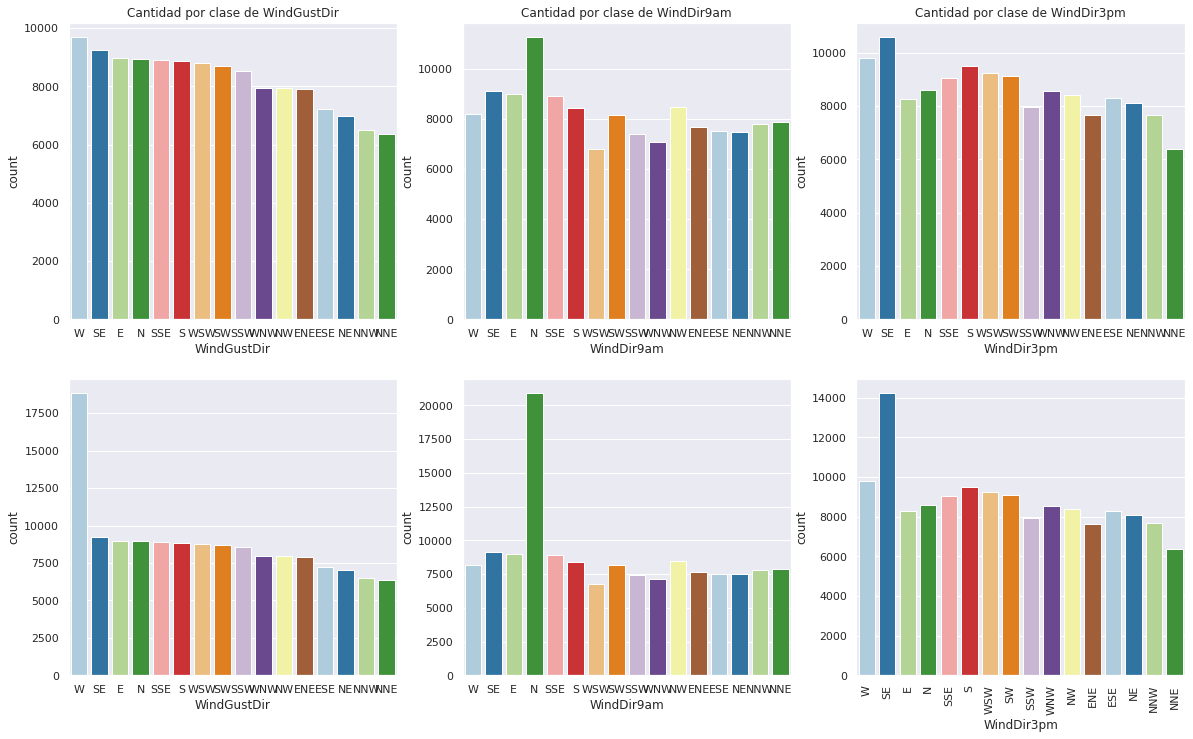

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

sns.countplot(data=XPrevious, x='WindGustDir', ax = ax[0,0], palette='Paired', 
              order=X['WindGustDir'].value_counts().index)
sns.countplot(data=XPrevious, x='WindDir9am', ax = ax[0,1],palette='Paired', 
              order=X['WindGustDir'].value_counts().index)
sns.countplot(data=XPrevious, x='WindDir3pm', ax = ax[0,2], palette='Paired', 
              order=X['WindGustDir'].value_counts().index)

df_mode = pd.DataFrame(cat_imputed_mode, columns=cols)
sns.countplot(data=df_mode, x='WindGustDir', ax = ax[1,0], palette='Paired', 
              order=df_mode['WindGustDir'].value_counts().index)
sns.countplot(data=df_mode, x='WindDir9am', ax = ax[1,1], palette='Paired', 
              order=df_mode['WindGustDir'].value_counts().index)
sns.countplot(data=df_mode, x='WindDir3pm', ax = ax[1,2], palette='Paired', 
              order=df_mode['WindGustDir'].value_counts().index)

ax[0,0].set_title('Cantidad por clase de WindGustDir')
ax[0,1].set_title('Cantidad por clase de WindDir9am')
ax[0,2].set_title('Cantidad por clase de WindDir3pm')
plt.xticks(rotation=90)
plt.show()

Se puede apreciar que lamentablemente se distorsionó la distribució n de las variables. 
Para utilizar MICE o KNN tenemos que codificar la imputacion de valores faltantes, para ellos utilizaremos la tecnica de One Hot Encoding para codificar las categorias del viento.

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140787 entries, 0 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           140787 non-null  datetime64[ns]
 1   Location       140787 non-null  object        
 2   MinTemp        140319 non-null  float64       
 3   MaxTemp        140480 non-null  float64       
 4   Rainfall       140787 non-null  float64       
 5   Evaporation    81093 non-null   float64       
 6   Sunshine       73982 non-null   float64       
 7   WindGustDir    140787 non-null  object        
 8   WindGustSpeed  131682 non-null  float64       
 9   WindDir9am     140787 non-null  object        
 10  WindDir3pm     140787 non-null  object        
 11  WindSpeed9am   139732 non-null  float64       
 12  WindSpeed3pm   138256 non-null  float64       
 13  Humidity9am    139270 non-null  float64       
 14  Humidity3pm    137286 non-null  float64       
 15  

In [51]:
wind_names = []
le = LabelEncoder()

cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
abb = {'WindGustDir':'WGD', 'WindDir9am':'WD9', 'WindDir3pm':'WD3'}
for col in cols:
  col_unique = X[col].unique().astype(str)
  col_sorted = [abb[col] + "_" + x for x in col_unique]
  wind_names.append(np.array(col_sorted))

In [52]:
ohe_encoder = OneHotEncoder(categories='auto',
                           drop=None, 
                           sparse=False
)
ohe_encoder.fit(X[cols].values)
wind_encoded = ohe_encoder.transform(X[cols].values)
cat_names = np.array(wind_names).ravel()
windir_df = pd.DataFrame(wind_encoded, columns=cat_names).astype(int)

In [53]:
#Hacemos reset index por que los dos dataframe a concatenar tiene indices distintos que percisten en el merge
X = pd.concat([X.reset_index(), windir_df], axis=1).drop(cols, axis=1)

In [54]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140787 entries, 0 to 140786
Data columns (total 71 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   index          140787 non-null  int64         
 1   Date           140787 non-null  datetime64[ns]
 2   Location       140787 non-null  object        
 3   MinTemp        140319 non-null  float64       
 4   MaxTemp        140480 non-null  float64       
 5   Rainfall       140787 non-null  float64       
 6   Evaporation    81093 non-null   float64       
 7   Sunshine       73982 non-null   float64       
 8   WindGustSpeed  131682 non-null  float64       
 9   WindSpeed9am   139732 non-null  float64       
 10  WindSpeed3pm   138256 non-null  float64       
 11  Humidity9am    139270 non-null  float64       
 12  Humidity3pm    137286 non-null  float64       
 13  Pressure9am    127044 non-null  float64       
 14  Pressure3pm    127018 non-null  float64       
 15  

In [55]:
# Creación de un nuevo dataframe de entrada sin Location ni Date
X_new = X.drop(['Location', 'Date'], axis=1)
X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140787 entries, 0 to 140786
Data columns (total 69 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          140787 non-null  int64  
 1   MinTemp        140319 non-null  float64
 2   MaxTemp        140480 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81093 non-null   float64
 5   Sunshine       73982 non-null   float64
 6   WindGustSpeed  131682 non-null  float64
 7   WindSpeed9am   139732 non-null  float64
 8   WindSpeed3pm   138256 non-null  float64
 9   Humidity9am    139270 non-null  float64
 10  Humidity3pm    137286 non-null  float64
 11  Pressure9am    127044 non-null  float64
 12  Pressure3pm    127018 non-null  float64
 13  Cloud9am       88162 non-null   float64
 14  Cloud3pm       84693 non-null   float64
 15  Temp9am        140131 non-null  float64
 16  Temp3pm        138163 non-null  float64
 17  RainToday      140787 non-nul

**Variables numericas (KNN o MICE)**



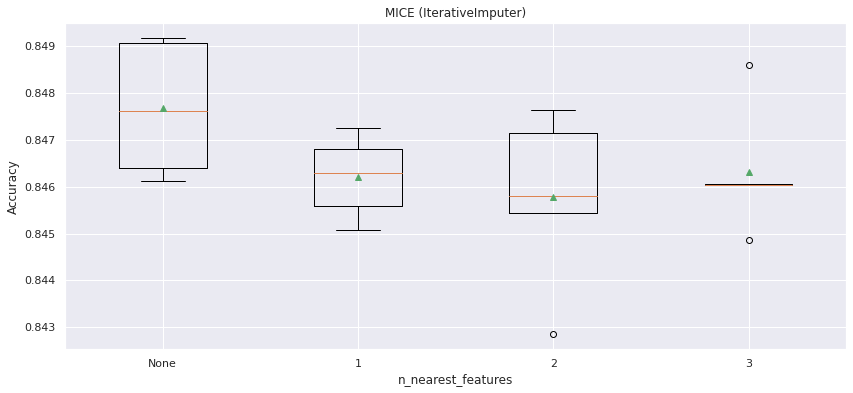

In [56]:
cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Day', 'Month', 'Year']
results=[]
param_grid = {
    "imputer__n_nearest_features": [None,1,2,3]
}
for param in param_grid["imputer__n_nearest_features"]:
    pipeline = Pipeline(steps=[( 'imputer' ,IterativeImputer(n_nearest_features=param)), ( 'lr' , LogisticRegression(max_iter=1000) )])
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(pipeline, X_new[cols], y, scoring= 'accuracy' , cv=cv, n_jobs=-1)    
    results.append(scores)
    
fig,axes = plt.subplots(1,figsize=(14,6))
axes.boxplot(results,labels=[x or "None" for x in param_grid["imputer__n_nearest_features"]],showmeans=True)
axes.set_xlabel("n_nearest_features")
axes.set_ylabel("Accuracy")
axes.set_title("MICE (IterativeImputer)");

In [57]:
mice_imputer = IterativeImputer(n_nearest_features=None)
cols_imputed = mice_imputer.fit_transform(X_new[cols])

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [58]:
X_new[cols] = cols_imputed
X_new.isna().sum()

index          0
MinTemp        0
MaxTemp        0
Rainfall       0
Evaporation    0
              ..
WD3_SE         0
WD3_N          0
WD3_S          0
WD3_NNE        0
WD3_NE         0
Length: 69, dtype: int64

In [59]:
y.isna().sum()

0

#### **Esquema de validación de resultados**
Vamos a separar el dataset en un conjunto de entrenamiento y otro de validacion.

In [60]:
#Como es un dataset desbalanceado, es deseable mantener el desbalance para eso se usa el comando stratify
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.2, random_state=42, stratify=y)
print("Cantidad de muestras para el entrenamiento: ", X_train.shape[0])
print("Cantidad de muestras para la validación: ", X_test.shape[0])
print("Cantidad de salidas para el entrenamiento: ", y_train.shape[0])
print("Cantidad de salidas para la validación: ", y_test.shape[0])

Cantidad de muestras para el entrenamiento:  112629
Cantidad de muestras para la validación:  28158
Cantidad de salidas para el entrenamiento:  112629
Cantidad de salidas para la validación:  28158


In [61]:
y_train.isna().sum()
y_train.head(20)

144971    0
104440    1
52420     0
137631    0
25368     0
101364    0
99282     0
140314    0
5193      1
83206     0
102895    1
80921     1
72230     0
101478    1
4946      0
120690    0
78027     0
123902    0
3335      0
130714    1
Name: RainTomorrow, dtype: int64

**Balanceamos el dataset** Para ello se van a concatenar los datos de entrada y la salida.

In [62]:
X_train['RainTomorrow'] = y_train
#X_train.insert(-1,"RainTomorrow",y_train,True)
#X_train.assign(RainTomorrow = y_train)
#X_train=pd.concat([X_train,y_train])
#X_train.loc[:,'RainTomorro4w'] = y_train
X_train.head(25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Day,Month,Year,WGD_W,WGD_WNW,WGD_WSW,WGD_NE,WGD_NNW,WGD_N,WGD_NNE,WGD_SW,WGD_ENE,WGD_SSE,WGD_S,WGD_NW,WGD_SE,WGD_ESE,WGD_E,WGD_SSW,WD9_W,WD9_NNW,WD9_SE,WD9_ENE,WD9_SW,WD9_SSE,WD9_S,WD9_NE,WD9_SSW,WD9_N,WD9_WSW,WD9_ESE,WD9_E,WD9_NW,WD9_WNW,WD9_NNE,WD3_WNW,WD3_WSW,WD3_E,WD3_NW,WD3_W,WD3_SSE,WD3_ESE,WD3_ENE,WD3_NNW,WD3_SSW,WD3_SW,WD3_SE,WD3_N,WD3_S,WD3_NNE,WD3_NE,RainTomorrow
140304,144971,23.4,41.3,0.0,11.570204,7.428301,44.0,19.0,6.0,42.000000,17.000000,1010.900000,1006.200000,4.598383,8.000000,30.6,39.5,0.0,23.0,2.0,2016.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
100742,104440,11.1,12.4,1.4,2.600000,0.000000,39.0,19.0,7.0,91.000000,95.000000,1019.000000,1016.500000,8.000000,8.000000,11.3,11.7,1.0,31.0,5.0,2014.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0
50453,52420,5.2,16.7,1.8,1.389579,2.313865,39.0,22.0,15.0,98.000000,99.000000,1017.726865,1015.672987,7.110167,8.134334,5.9,11.6,1.0,24.0,11.0,2009.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
133083,137631,10.9,15.1,2.6,2.200000,0.000000,28.0,6.0,15.0,88.000000,81.000000,1025.600000,1023.100000,8.000000,8.000000,12.6,14.9,1.0,7.0,6.0,2013.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
24489,25368,9.0,18.8,12.6,2.561163,5.957551,50.0,4.0,9.0,100.000000,39.000000,1014.219955,1013.809818,5.437520,5.089623,13.1,17.6,1.0,25.0,5.0,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
97690,101364,11.6,21.1,0.4,2.400000,5.900000,41.0,15.0,26.0,94.000000,63.000000,1025.100000,1022.800000,8.000000,7.000000,13.3,20.0,0.0,25.0,3.0,2014.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0
95613,99282,15.3,26.2,0.0,8.670401,7.712179,44.0,11.0,19.0,44.000000,49.000000,1005.400000,1004.500000,4.628002,5.286331,20.6,22.3,0.0,7.0,11.0,2016.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN
135751,140314,25.7,32.3,0.0,5.000000,4.300000,31.0,11.0,13.0,67.000000,78.000000,1010.900000,1007.800000,3.000000,6.000000,30.1,28.4,0.0,16.0,11.0,2011.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0
5040,5193,20.2,24.4,4.4,3.312404,3.076249,22.0,4.0,6.0,96.000000,90.000000,1017.100000,1015.700000,7.366354,6.986800,21.3,22.6,1.0,21.0,2.0,2015.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0
79975,83206,4.9,16.2,0.0,0.800000,0.000000,20.0,0.0,2.0,94.077734,67.275792,1023.200000,1017.200000,7.441182,7.601185,8.2,15.9,0.0,17.0,4.0,2015.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0


In [63]:
X_train['RainTomorrow'].isna().sum()# PORQUE GENERA NANS??????????????????????

25410

In [64]:
# Por alguna razon al concatenar RainTomorrow se generaron NaNs que deben
# ser eliminados para continuar, esto no debería pasar.
X_train=X_train.dropna()
X_train['RainTomorrow'].isna().sum()

0

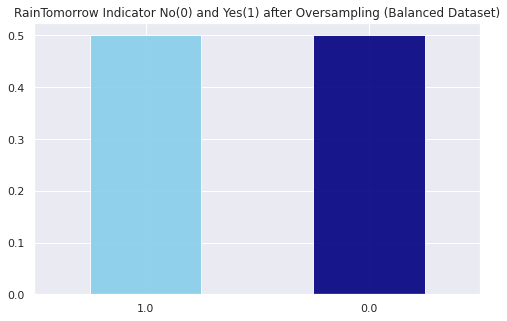

In [65]:
from sklearn.utils import resample
no = X_train[X_train.RainTomorrow == 0]
yes = X_train[X_train.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
df_oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
df_oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [66]:
df_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135556 entries, 50453 to 1636
Data columns (total 70 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          135556 non-null  int64  
 1   MinTemp        135556 non-null  float64
 2   MaxTemp        135556 non-null  float64
 3   Rainfall       135556 non-null  float64
 4   Evaporation    135556 non-null  float64
 5   Sunshine       135556 non-null  float64
 6   WindGustSpeed  135556 non-null  float64
 7   WindSpeed9am   135556 non-null  float64
 8   WindSpeed3pm   135556 non-null  float64
 9   Humidity9am    135556 non-null  float64
 10  Humidity3pm    135556 non-null  float64
 11  Pressure9am    135556 non-null  float64
 12  Pressure3pm    135556 non-null  float64
 13  Cloud9am       135556 non-null  float64
 14  Cloud3pm       135556 non-null  float64
 15  Temp9am        135556 non-null  float64
 16  Temp3pm        135556 non-null  float64
 17  RainToday      135556 non-n

**Análisis de outliers**

In [67]:
# Detectar outliers con IQR
Q1 = df_oversampled.quantile(0.25)
Q3 = df_oversampled.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

index           72135.000000
MinTemp             9.300000
MaxTemp            10.100000
Rainfall            0.800000
Evaporation         4.224217
                    ...     
WD3_N               0.000000
WD3_S               0.000000
WD3_NNE             0.000000
WD3_NE              0.000000
RainTomorrow        1.000000
Length: 70, dtype: float64


**Matriz de correlacion**

A continuacion analizaremos la matriz de correlacion para analizar que valores se pueden excluir del modelo por ser fuertemente correlacionados

<function matplotlib.pyplot.show>

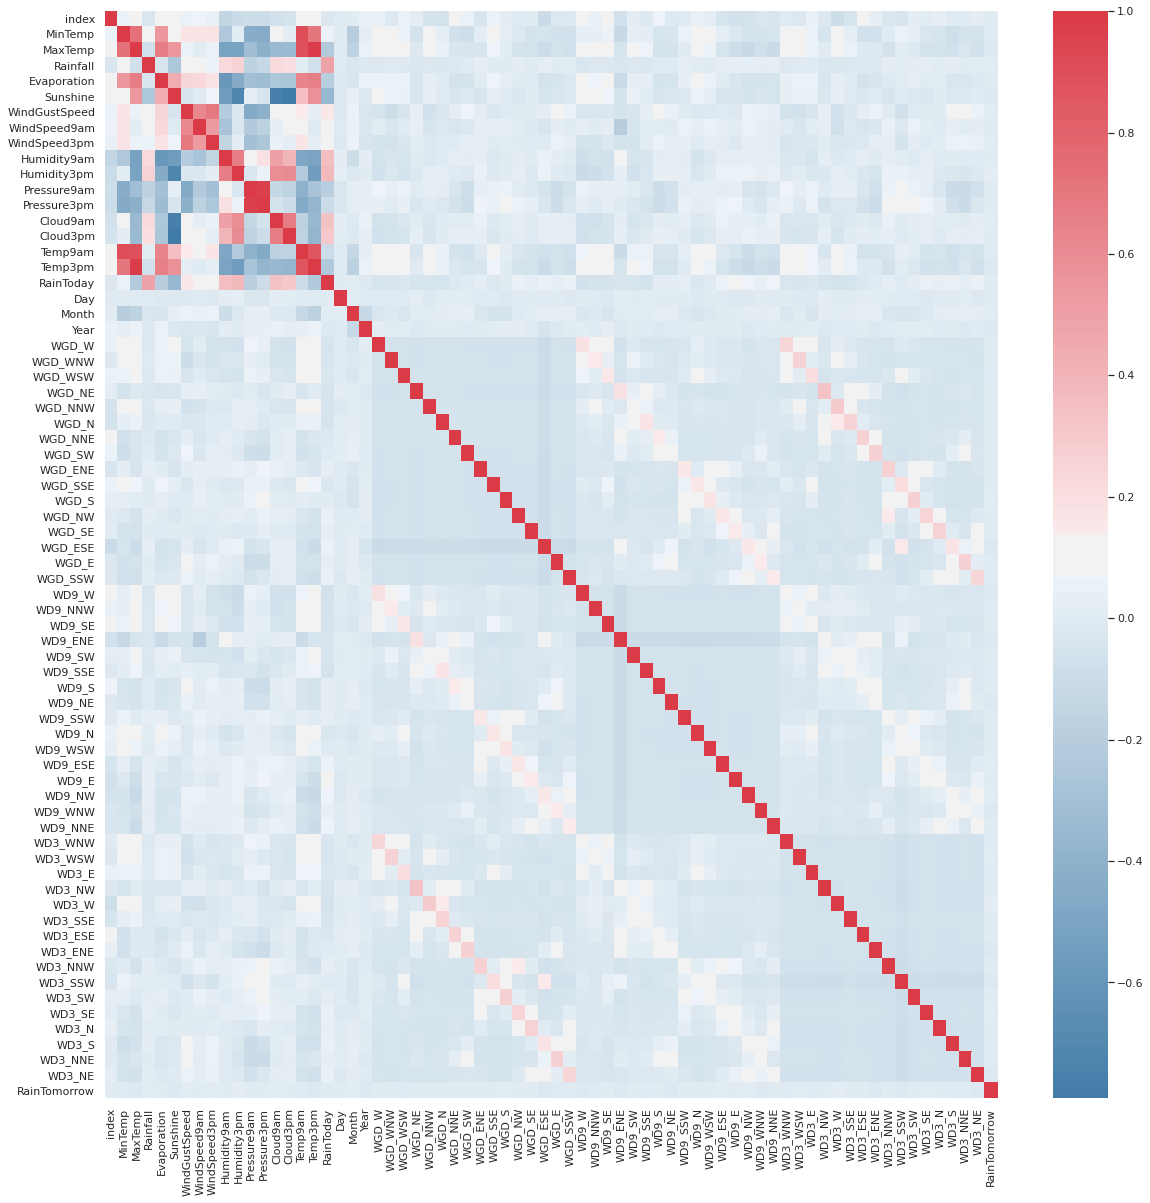

In [68]:
# plotting a correlation matrix 
plt.figure(figsize=(20,20))
sns.heatmap(df_oversampled.corr(), cmap=sns.diverging_palette(240,10,as_cmap=True),annot=False);
plt.xticks(rotation=90)
plt.show

Como se puede observar en la matriz de correlacion:
*   Temp9am y MaxTemp estan altamente correlacionados
*   Temp9am y MinTemp estan altamente correlacionados
*   Temp3pm y MaxTemp estan altamente correlacionados
*   Temp3pm y MinTemp estan altamente correlacionados
*   Pressure9am y Pressure3pm estan altamente correlacionados
*   MinTemp y MaxTemp estan altamente correlacionados

Por ello, para redicir el tamaño del dataset se eliminaran las columnas que estan altamente correlacionadas.

In [69]:
# Hacemor drop de las columnas altamente correlacionadas y de la salida
df_oversampled.drop(["Temp9am", "Temp3pm", "Pressure3pm"], axis=1, inplace=True)
df_oversampled.columns

Index(['index', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm', 'RainToday',
       'Day', 'Month', 'Year', 'WGD_W', 'WGD_WNW', 'WGD_WSW', 'WGD_NE',
       'WGD_NNW', 'WGD_N', 'WGD_NNE', 'WGD_SW', 'WGD_ENE', 'WGD_SSE', 'WGD_S',
       'WGD_NW', 'WGD_SE', 'WGD_ESE', 'WGD_E', 'WGD_SSW', 'WD9_W', 'WD9_NNW',
       'WD9_SE', 'WD9_ENE', 'WD9_SW', 'WD9_SSE', 'WD9_S', 'WD9_NE', 'WD9_SSW',
       'WD9_N', 'WD9_WSW', 'WD9_ESE', 'WD9_E', 'WD9_NW', 'WD9_WNW', 'WD9_NNE',
       'WD3_WNW', 'WD3_WSW', 'WD3_E', 'WD3_NW', 'WD3_W', 'WD3_SSE', 'WD3_ESE',
       'WD3_ENE', 'WD3_NNW', 'WD3_SSW', 'WD3_SW', 'WD3_SE', 'WD3_N', 'WD3_S',
       'WD3_NNE', 'WD3_NE', 'RainTomorrow'],
      dtype='object')

In [70]:
df_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135556 entries, 50453 to 1636
Data columns (total 67 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          135556 non-null  int64  
 1   MinTemp        135556 non-null  float64
 2   MaxTemp        135556 non-null  float64
 3   Rainfall       135556 non-null  float64
 4   Evaporation    135556 non-null  float64
 5   Sunshine       135556 non-null  float64
 6   WindGustSpeed  135556 non-null  float64
 7   WindSpeed9am   135556 non-null  float64
 8   WindSpeed3pm   135556 non-null  float64
 9   Humidity9am    135556 non-null  float64
 10  Humidity3pm    135556 non-null  float64
 11  Pressure9am    135556 non-null  float64
 12  Cloud9am       135556 non-null  float64
 13  Cloud3pm       135556 non-null  float64
 14  RainToday      135556 non-null  float64
 15  Day            135556 non-null  float64
 16  Month          135556 non-null  float64
 17  Year           135556 non-n

**Análisis de features más importantes**

Se observa a continuación el gráfico de la varianza explicada del dataset según el número de componentes del PCA. Se podría realizar una reducción de dimensionalidad pero por cuestiones de tiempo, no se realizará en el presente trabajo.

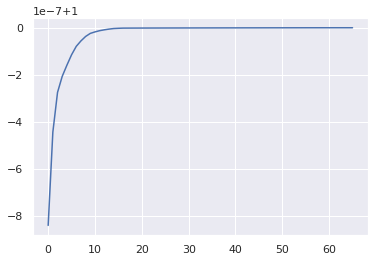

In [103]:
df_oversampledAux = df_oversampled.copy()
df_oversampledAux.drop(['RainTomorrow'], axis=1, inplace=True)
# Análisis de features más importantes
sk_pca = PCA()
sk_pca.fit(df_oversampledAux)
#print(sk_pca.explained_variance_ratio_.cumsum())
plt.plot(sk_pca.explained_variance_ratio_.cumsum()); 
plt.grid(True);


### **4. Entrenamiento de modelos**

Una vez que tenemos el dataset con todos los NaN imputados, balanceado y con las columnas altamente correlacioandas eliminadas, procedemos a entrenar el modelo. Primero vamos a aplicar RandomForest y luego Regresion Logistica.


In [74]:
df_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135556 entries, 50453 to 1636
Data columns (total 67 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          135556 non-null  int64  
 1   MinTemp        135556 non-null  float64
 2   MaxTemp        135556 non-null  float64
 3   Rainfall       135556 non-null  float64
 4   Evaporation    135556 non-null  float64
 5   Sunshine       135556 non-null  float64
 6   WindGustSpeed  135556 non-null  float64
 7   WindSpeed9am   135556 non-null  float64
 8   WindSpeed3pm   135556 non-null  float64
 9   Humidity9am    135556 non-null  float64
 10  Humidity3pm    135556 non-null  float64
 11  Pressure9am    135556 non-null  float64
 12  Cloud9am       135556 non-null  float64
 13  Cloud3pm       135556 non-null  float64
 14  RainToday      135556 non-null  float64
 15  Day            135556 non-null  float64
 16  Month          135556 non-null  float64
 17  Year           135556 non-n

In [75]:
# Separamos RainTomorrow
xTrain = df_oversampled.drop('RainTomorrow', axis=1)
yTrain = df_oversampled["RainTomorrow"]

In [76]:
xTrain.shape

(135556, 66)

In [77]:
X_test.drop(["Temp9am", "Temp3pm", "Pressure3pm"], axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Normalización del dataset**

In [78]:
# Normalización de los datos a media cero y varianza unitaria
scaler = StandardScaler()
scaler.fit(xTrain)

def zscore(X):
  return pd.DataFrame(scaler.transform(X))

xTrain = zscore(xTrain)
X_test = zscore(X_test)

**Random Forest**

In [79]:
%%time
# Instantiate the model
clf1 = RandomForestClassifier(n_jobs=-1, random_state=12)
# Fit the model
clf1.fit(xTrain, yTrain)

CPU times: user 1min 19s, sys: 729 ms, total: 1min 20s
Wall time: 41.1 s


In [80]:
# score the model
sc1 = round(100*clf1.score(X_test, y_test),2)
print("Accuracy: " + str(sc1) + "%")

Accuracy: 77.24%


In [81]:
y_preds = clf1.predict(X_test)

In [82]:
print(confusion_matrix(y_test, y_preds))

[[21701   217]
 [ 6192    48]]


In [83]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87     21918
           1       0.18      0.01      0.01      6240

    accuracy                           0.77     28158
   macro avg       0.48      0.50      0.44     28158
weighted avg       0.65      0.77      0.68     28158



**Regresión Logística**

In [84]:
%%time
# Instantiate the model
clf2 = LogisticRegression(n_jobs=-1, random_state=12)
# Fit the model
clf2.fit(xTrain, yTrain)

CPU times: user 93.8 ms, sys: 311 ms, total: 404 ms
Wall time: 4.11 s


In [85]:
# score the model
sc2 = round(100*clf2.score(X_test, y_test),2)
print("Accuracy: " + str(sc2) + "%")

Accuracy: 54.95%


In [86]:
# make a confusion matrix and classification report
y_preds = clf2.predict(X_test)
print(confusion_matrix(y_test, y_preds))

[[11730 10188]
 [ 2497  3743]]


In [87]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.82      0.54      0.65     21918
           1       0.27      0.60      0.37      6240

    accuracy                           0.55     28158
   macro avg       0.55      0.57      0.51     28158
weighted avg       0.70      0.55      0.59     28158



**Clasificador LGBM**

In [88]:
%%time
# Instantiate the model
clf3 = LGBMClassifier()
# Fit the model
clf3.fit(xTrain, yTrain)

CPU times: user 9.3 s, sys: 342 ms, total: 9.64 s
Wall time: 5.32 s


In [89]:
# score the model
sc3 = round(100*clf3.score(X_test, y_test),2)
print("Accuracy: " + str(sc3) + "%")

Accuracy: 55.2%


In [90]:
# make a confusion matrix and classification report
y_preds = clf3.predict(X_test)
print(confusion_matrix(y_test, y_preds))

[[12540  9378]
 [ 3238  3002]]


In [91]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.79      0.57      0.67     21918
           1       0.24      0.48      0.32      6240

    accuracy                           0.55     28158
   macro avg       0.52      0.53      0.49     28158
weighted avg       0.67      0.55      0.59     28158



Después de entrenar y evaluar 3 modelos, observamos que Random Forest da mejores resultados que Regresión Logística.